In [172]:
!pip install plotnine --quiet

# Imports

In [352]:
import torch_geometric 
from typing import Callable, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict
from torch_geometric.utils import get_laplacian
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
from torch_geometric.utils import to_scipy_sparse_matrix
from dataclasses import dataclass

# Datasets initial exploration

In [353]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name)
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 
Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 
Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


# Glorot Normalization

In [354]:
dataset[0] = Planetoid("/tmp/Cora", name="Cora")
print(f"Sum of row values without normalization: {dataset[0][0].x.sum(dim=-1)}")

dataset[0] = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[0][0].x.sum(dim=-1)}")
print(" ")

dataset[1] = Planetoid("/tmp/CiteSeer", name="CiteSeer")
print(f"Sum of row values without normalization: {dataset[1][0].x.sum(dim=-1)}")

dataset[1] = Planetoid("/tmp/CiteSeer", name="CiteSeer", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[1][0].x.sum(dim=-1)}")
print(" ")

dataset[2] = Planetoid("/tmp/PubMed", name="PubMed")
print(f"Sum of row values without normalization: {dataset[2][0].x.sum(dim=-1)}")

dataset[2] = Planetoid("/tmp/PubMed", name="PubMed", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[2][0].x.sum(dim=-1)}")


Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
 
Sum of row values without normalization: tensor([31., 33., 25.,  ..., 40., 36., 26.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
 
Sum of row values without normalization: tensor([1.5913, 1.6492, 1.8888,  ..., 1.7013, 2.0314, 1.8369])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


# 2 layer GCN set-up as in the paper

In [355]:
class GCN(torch.nn.Module):
    
    def __init__(
        self,
        num_node_features:int,
        num_classes:int, 
        hidden_dim: int=16,
        dropout_rate: float=0.1,
        num_hidden_layers=0,
        residual=False
        ) -> None: 
        super().__init__()
        self.dropout1=torch.nn.Dropout(dropout_rate)
        self.conv1=GCNConv(num_node_features, hidden_dim)
        self.relu=torch.nn.ReLU(inplace=True)
        self.hidden_convs =  torch.nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)])
        self.dropout2=torch.nn.Dropout(dropout_rate)
        self.conv2=GCNConv(hidden_dim, num_classes)

    def forward(self, x:Tensor, edge_index: Tensor)-> torch.Tensor:
            x=self.dropout1(x)
            x=self.conv1(x, edge_index)
            x=self.relu(x)
            for conv in self.hidden_convs:
                if residual:
                    x = self.relu(conv(x, edge_index)) + x
                else:
                    x = self.relu(conv(x, edge_index))
            x=self.dropout2(x)
            x=self.conv2(x, edge_index)
            return x


In [356]:
print(GCN(dataset[0].num_node_features, dataset[0].num_classes,num_hidden_layers=3,residual=False))


GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList(
    (0): GCNConv(16, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
  )
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 7)
)


In [357]:
    
print("Graph Convolutional Network (GCN):")
print(GCN(dataset[0].num_node_features, dataset[0].num_classes))

    
print("Graph Convolutional Network (GCN):")
print(GCN(dataset[1].num_node_features, dataset[1].num_classes))

    
print("Graph Convolutional Network (GCN):")
print(GCN(dataset[2].num_node_features, dataset[2].num_classes))



Graph Convolutional Network (GCN):
GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 7)
)
Graph Convolutional Network (GCN):
GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(3703, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 6)
)
Graph Convolutional Network (GCN):
GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(500, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 3)
)


# Train and eval steps

In [359]:
# we reb not using the original implementation of he framework 
# in fact we re using the model provided by Pytorch
LossFn= Callable[[Tensor, Tensor], Tensor]
Stage= Literal["train", "val", "test"]

def train_step(
    model: torch.nn.Module, data:Data, optimizer: torch.optim.Optimizer, loss_fn:LossFn)-> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss= loss_fn(logits, y)
    acc=accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model:torch.nn.Module, data:Data, loss_fn:LossFn, stage:Stage)-> Tuple[float, float]:
    model.eval()
    mask=getattr(data, f"{stage}_mask")
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss=loss_fn(logits, y)
    acc=accuracy(preds, y)
    return loss.item(), acc 





In [360]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = False,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [316]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(dataset[0].num_node_features, dataset[0].num_classes).to(device)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model2 = GCN(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history2 = train(model2, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model3 = GCN(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history3= train(model3, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)



Epoch: 0
----------
Train loss: 1.9454 | Train acc: 0.1286
  Val loss: 1.9424 |   Val acc: 0.1360

Epoch: 20
----------
Train loss: 1.6455 | Train acc: 0.7929
  Val loss: 1.7833 |   Val acc: 0.4500

Epoch: 40
----------
Train loss: 1.1851 | Train acc: 0.9500
  Val loss: 1.5146 |   Val acc: 0.7260

Epoch: 60
----------
Train loss: 0.7669 | Train acc: 0.9714
  Val loss: 1.2411 |   Val acc: 0.7620

Epoch: 80
----------
Train loss: 0.5343 | Train acc: 0.9786
  Val loss: 1.0533 |   Val acc: 0.7760

Epoch: 100
----------
Train loss: 0.3996 | Train acc: 0.9786
  Val loss: 0.9564 |   Val acc: 0.7680

Early stopping...

Epoch: 118
----------
Train loss: 0.3455 | Train acc: 1.0000
  Val loss: 0.9212 |   Val acc: 0.7700
 Test loss: 0.8893 |  Test acc: 0.7970

Epoch: 0
----------
Train loss: 1.7919 | Train acc: 0.1500
  Val loss: 1.7901 |   Val acc: 0.2120

Epoch: 20
----------
Train loss: 1.5244 | Train acc: 0.9083
  Val loss: 1.6834 |   Val acc: 0.6620

Epoch: 40
----------
Train loss: 1.1607 |

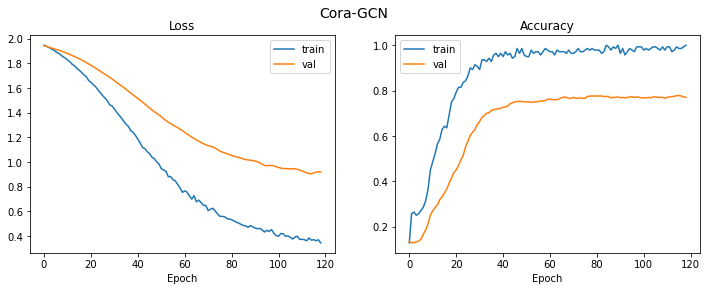

In [88]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-GCN")



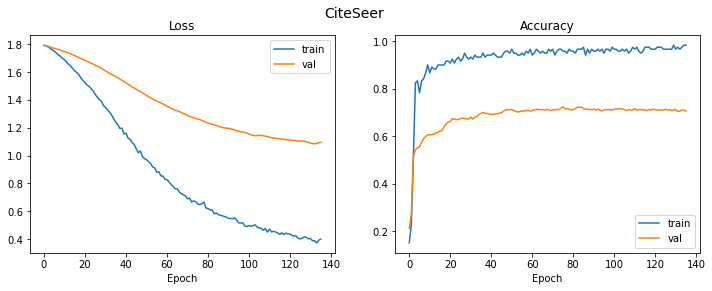

In [90]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer")

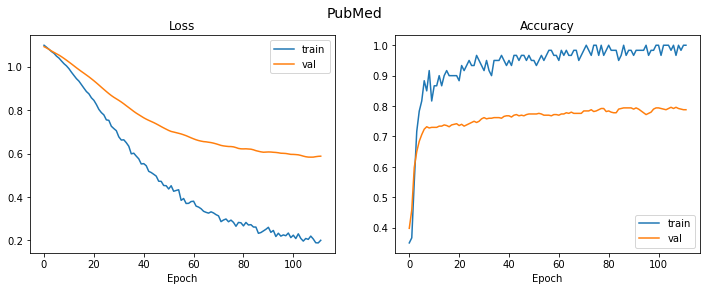

In [91]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed")

# ChebNet Convolution 

In [ ]:
from torch 

In [102]:
data = dataset[0][0].to(device)


In [361]:
class ChebNet(torch.nn.Module):
    def __init__(
        self,
        num_node_features:int,
        num_classes:int, 
        hidden_dim: int=16,
        dropout_rate: float=0.2,
        k=2,
        num_hidden_layers=0,
        residual=False
        ) -> None: 
        super().__init__()
        self.dropout1=torch.nn.Dropout(dropout_rate)
        self.conv1=ChebConv(num_node_features, hidden_dim,k)
        self.relu=torch.nn.ReLU(inplace=True)
        self.hidden_convs =  torch.nn.ModuleList([ChebConv(hidden_dim, hidden_dim, k) for _ in range(num_hidden_layers)])
        self.dropout2=torch.nn.Dropout(dropout_rate)
        self.conv2=ChebConv(hidden_dim, num_classes,k)

    def forward(self, x:Tensor, edge_index: Tensor)-> torch.Tensor:
            
            x=self.dropout1(x)
            x=self.conv1(x, edge_index)
            x=self.relu(x)
            for conv in self.hidden_convs:
                if residual:
                    x = self.relu(conv(x, edge_index)) + x
                else:
                    x = self.relu(conv(x, edge_index))
            x=self.dropout2(x)
            x=self.conv2(x, edge_index)
            return x

In [158]:
print(ChebNet(dataset[0].num_node_features, dataset[0].num_classes, num_hidden_layers=0))


ChebNet(
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): ChebConv(1433, 16, K=2, normalization=sym)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv2): ChebConv(16, 7, K=2, normalization=sym)
)


In [126]:
print("Graph Convolutional Network (GCN):")
print(ChebNet(dataset[0].num_node_features, dataset[0].num_classes))



Graph Convolutional Network (GCN):
ChebNet(
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): ChebConv(1433, 16, K=2, normalization=sym)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv2): ChebConv(16, 7, K=2, normalization=sym)
)


In [136]:
model4 = GCN(dataset[0].num_node_features, dataset[0].num_classes).to(device)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history4 = train(model4, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model5 = GCN(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history5 = train(model5, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model6 = GCN(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history6= train(model6, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)



Epoch: 0
----------
Train loss: 1.9465 | Train acc: 0.1571
  Val loss: 1.9436 |   Val acc: 0.2760

Epoch: 20
----------
Train loss: 1.6939 | Train acc: 0.9214
  Val loss: 1.8065 |   Val acc: 0.7020

Epoch: 40
----------
Train loss: 1.2259 | Train acc: 0.9500
  Val loss: 1.5416 |   Val acc: 0.7580

Epoch: 60
----------
Train loss: 0.7937 | Train acc: 0.9714
  Val loss: 1.2505 |   Val acc: 0.7780

Epoch: 80
----------
Train loss: 0.5371 | Train acc: 0.9857
  Val loss: 1.0620 |   Val acc: 0.7860

Epoch: 100
----------
Train loss: 0.4227 | Train acc: 0.9857
  Val loss: 0.9729 |   Val acc: 0.7920

Epoch: 120
----------
Train loss: 0.3576 | Train acc: 0.9857
  Val loss: 0.9137 |   Val acc: 0.7840

Epoch: 140
----------
Train loss: 0.3063 | Train acc: 0.9929
  Val loss: 0.8589 |   Val acc: 0.7940

Epoch: 160
----------
Train loss: 0.2698 | Train acc: 0.9929
  Val loss: 0.8360 |   Val acc: 0.7900

Early stopping...

Epoch: 162
----------
Train loss: 0.2811 | Train acc: 0.9929
  Val loss: 0.84

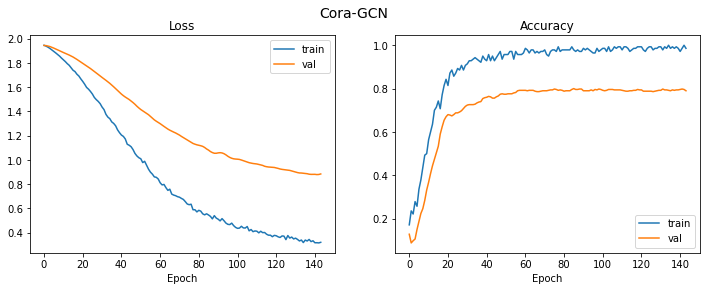

In [132]:
plt.figure(figsize=(12, 4))
plot_history(history4, "Cora-GCN")

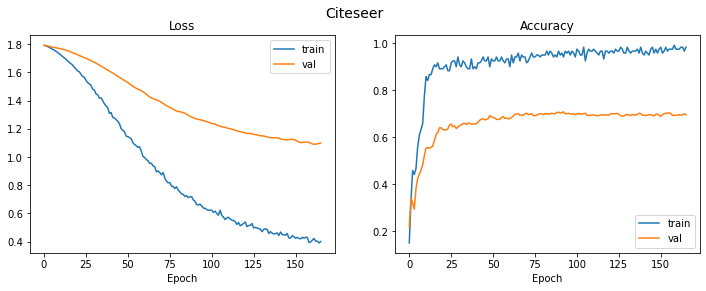

In [133]:
plt.figure(figsize=(12, 4))
plot_history(history5, "Citeseer")

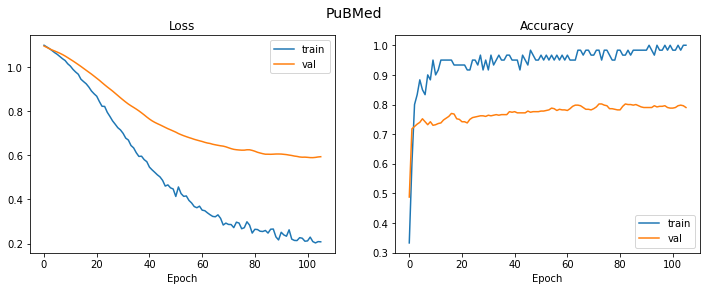

In [134]:
plt.figure(figsize=(12, 4))
plot_history(history6, "PuBMed")

# Model depth experiments and effect of residual connections 

In [222]:
model = GCN(dataset[0].num_node_features, dataset[0].num_classes).to(device)
data = dataset[0][0].to(device)


In [223]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [401]:
hidden_layers= list(range(9))
#dataset[0]
def compute_accuracy_per_hidden_layer_num(data,residual,hidden_layers):
    overall_train_accs, overall_test_accs = [], []
    num_node_features=data.num_node_features
    num_classes=data.num_classes
    data = data[0].to(device)
    train_accs, test_accs = [], []
    for i in hidden_layers:
        
        model = GCN(num_node_features, num_classes,num_hidden_layers=i,residual=residual).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)
        train_accs.append(history['acc'][-1])
        test_loss, test_acc = eval_step(model, data, torch.nn.CrossEntropyLoss(), "test")
        test_accs.append(test_acc)

    return train_accs,test_accs

In [405]:
def compute_residual_effect_df(data):
    SEED = 42
    MAX_EPOCHS = 200
    LEARNING_RATE = 0.01
    WEIGHT_DECAY = 5e-4
    EARLY_STOPPING = 10
    hidden_layers = list(range(9))
    train_accs, test_accs=compute_accuracy_per_hidden_layer_num(data,True,hidden_layers=hidden_layers)
    res_train_accs, res_test_accs=compute_accuracy_per_hidden_layer_num(data,False,hidden_layers=hidden_layers)
    h = len(hidden_layers)
    print(train_accs, test_accs)
    print(res_train_accs, res_test_accs)
    df = pd.DataFrame({
        "Layer": hidden_layers * 4,
        "Accuracy": train_accs + test_accs + res_train_accs + res_test_accs,
        "Type": ["Train"] * h + ["Test"] * h + ["Train"] * h + ["Test"] * h,
        "Residual": ["No residual"] * (2 * h) + ["Residual"] * (2 * h)
    })
    return df

In [406]:
df=compute_residual_effect_df(dataset[0])

[0.9928571428571429, 1.0, 0.9714285714285714, 0.9571428571428572, 0.9785714285714285, 0.9571428571428572, 0.9142857142857143, 0.9571428571428572, 0.7142857142857143] [0.807, 0.805, 0.75, 0.676, 0.697, 0.728, 0.714, 0.674, 0.592]
[0.9785714285714285, 0.9928571428571429, 0.9857142857142858, 0.9714285714285714, 0.9571428571428572, 0.8071428571428572, 0.7428571428571429, 0.8857142857142857, 0.6357142857142857] [0.801, 0.784, 0.734, 0.741, 0.703, 0.584, 0.63, 0.612, 0.465]


In [409]:
def plot_residual_effect(df, dataset):
    print(ggplot(df, aes(x="Layer", y="Accuracy", color="factor(Type)", linetype="factor(Residual)")) +
      geom_line() + 
      theme(legend_title=element_blank()) + 
      xlab("Number of hidden layers") +
      ggtitle(f"Accuracy vs number of hidden layers (residual/no residual) - {dataset.name}")
    )

In [407]:
%%capture
df_cora = compute_residual_effect_df(dataset[0])
plot_residual_effect(df_cora, dataset[0])

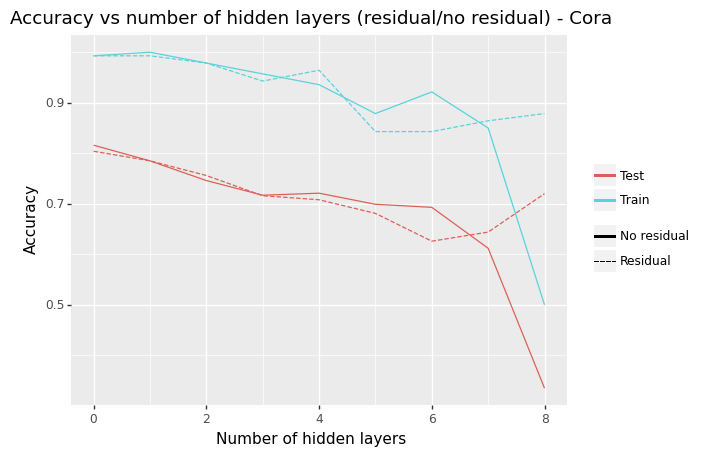

In [410]:
plot_residual_effect(df_cora, dataset[0])

In [414]:
%%capture
df_citeseer = compute_residual_effect_df(dataset[1])


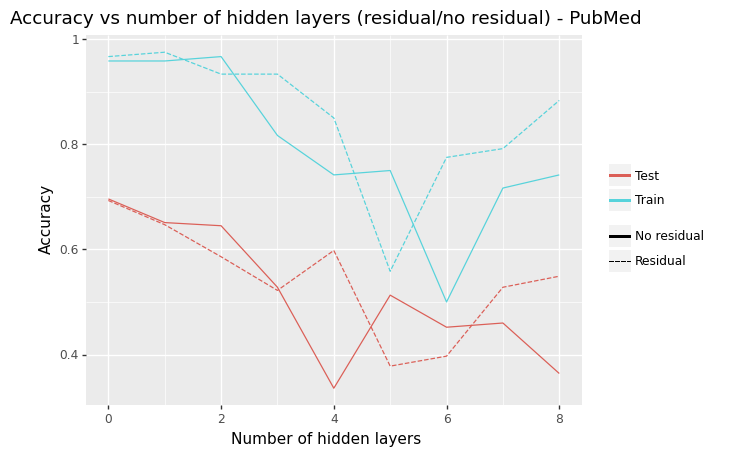

In [416]:
plot_residual_effect(df_citeseer, dataset[2])

In [417]:
%%capture
df_pubmed = compute_residual_effect_df(dataset[2])


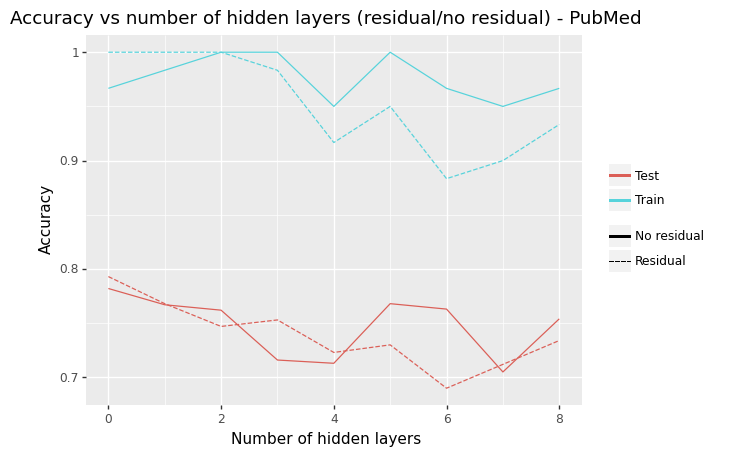

In [418]:
plot_residual_effect(df_pubmed, dataset[2])